# ST7 Planification quotidienne d’une équipe mobile

In [1]:
# Modules de base
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
from utils import parse_time, parse_time_minute

import matplotlib.pyplot as plt
%matplotlib inline

# Module relatif à Gurobi
from gurobipy import *

# Utilités
from math import ceil
import utils
from importlib import reload

### Notations
- $ W $ : Nombre de tâches (W pour work)
- $ U $ : Nombre d’indisponibilités (unavail pour Unavailable)
- $ T $ : Nombre de employés (T pour Technician)
- $ V = 2 \times T + W + U$ : Le nombre total de nœuds

### Les indices des nœuds

Tout comme notre modèle dans la phase 1, Dans notre modèle pour la phase 2, nous allons utiliser le modèle de graphe pour résoudre notre problème. Dans la phase 1, les nœuds sont les tâches à effectuer, ainsi qu’un nœud symbolisant le dépôt initial d’où partent les employés. Dans la phase 2, le rajout de contraintes tels que la pause midi/déjeuner et les indisponibilités nous amène à distinguer quatre types de nœuds : Les lieux de résidences des employés (home), les tâches (task), les nœuds auxiliaires fictifs/dummy nodes correspondant aux pauses déjeuners des employés (lunch) et enfin les indisponibilités (unavail). Afin de faciliter la lecture, nous utilisons les notations suivantes pour les indices des quatre types de nœuds : 

- $ homes = \{0, ..., T - 1\} $ sont les indices des lieux de résidence / maison des employés
- $ lunches = \{T, ..., 2T - 1\} $ : les indices des pauses midi, ie. les déjeuners
- $ tasks = \{2T, ... 2T + W - 1\} $ : les indices des tâches à réaliser
- $ unavails = \{2T + W, ..., V - 1 \} $ : les indisponibilités des employés

L’ensemble des nœuds est donc : 
- $ nodes = homes \cup lunches \cup tasks \cup unavails = \{0, ..., V - 1\} $

Quant aux indices des employés, ils sont les mêmes que les indices de leurs maisons : 
- $ employees = \{0, ..., T - 1 \} $

Par la suite, lorsque l’on note $i \in homes$, cela signifie $i \in \{0, ..., T - 1\}$, idem pour les autres types de nœuds.

Les nœuds homes, lunches, unavails doivent être visité par leurs employés correspondants. Nous utilisons les notations suivantes pour ces correspondances : 
- $ home(k), k \in employees $ : L’indice du lieu de résidence de l’employé k
- $ lunch(k), k \in employees $ : L’indice du nœud correspondant à la pause déjeuner de l’employé k. Nous modélisons la pause déjeuner comme une tâche fictive.

Dans la phase 2 du projet, les tâches sont ouvertes sur plusieurs créneaux de temps. Les indisponibilités sont notées : 
- $ closedIntervals(i), i \in tasks $ : Ensemble des (start, end) des indisponibilités de la tâche i.

Notez que ce ne sont pas des variables de décisions et ne changent pas au cours du temps, malgré la notation entre parenthèse.

### À propos des pauses déjeuners
Dans une perspective de pure optimisation, nous aurions pu considérer que les employés effectuent leurs pauses déjeuners en plein milieu de la trajectoire rectiligne du trajet entre une tâche et la suivante. Pourtant, il nous semble que cette manière de représenter les pauses déjeuners correspondent peu à la réalité, et il nous paraît plus naturel qu’après avoir effectué la dernière tâche du matin, un employé mange et se repose sur place, et ensuite qu’il prenne sa route vers la prochaine destination. Cela nous amène à modéliser les pauses déjeuners ainsi :

Nous modélisons les pauses midi de chaque employé comme une «pseudo-tâche» d’une durée d’une heure, qui s’ouvrent à 12h et qui ferment à 14h, que l’employé doit obligatoirement effectuer. Comme l’employé effectuer cette tâche sur place (donc pas de temps de trajet entre la dernière tâche du matin et la pause déjeuner, la pause déjeuner a une distance de 0 vers les autres nœuds. Un employé effectuer la dernière tâche du matin, se rend sur cette « pseudo-nœuds », et ensuite retourne vers le nœud de la tâche du matin, comme illustre l’image suivante : 


<img src="./images/lunch_illustration.jpeg" alt="lunch-illustration" width=500>

### Nous notons les constantes suivante : 

- $ opening_i, i \in tasks \cup unavails $ : l’ouverture de la tâche i / début de l’indisponibilité i
- $ closing_i, i \in tasks \cup unavails $ : la fermeture de la tâche i / fin de l’indisponibilité i
- $ start_k, k \in employees $ : le début de la journée de l’employé k
- $ end_k, k \in employees $ la fin de la journée de d’employé k
- $ duration_i $ : la durée de la tâche/indisponibilité/ i
- $ distance_{i, j} $ : la distance entre le nœud i et le nœud j
- $ speed $ : la vitesse de déplacement des techniciens

### Variables de décisions
- $ (x_{i, j})_{i , j \in nodes \times nodes, i \neq j} $, $ x_{i, j} = 1 $ ssi. (i, j) est un arc de i vers j
- $ (y_{k, i})_{k \in employees, i \in tasks} $, $ y_{k, i} = 1 $ ssi. le technicien k se rend au nœud i (Pour les indices i correspondant aux lieux de résidence/ pauses déjeuners /indisponibilités des employés, la notation est la même, sauf que les valeurs sont fixes car on connaît la relation entre ces nœuds et leurs employés correspondants)
- $ (b_i)_i $, $b_i$ est le début de chaque tâche en minute (b pour beginning)

### Contraintes :

- (C1) Chaque nœud doit avoir autant d’entrée que de sorties
$$ \forall i \in nodes, \sum_{j = 0}^{V - 1} x_{i, j} = \sum_{j = 0}^{V - 1} x_{j, i} $$

En effet, les employés doivent former des cycles en partant de son lieu de résidence, et en terminant son parcours à son lieu de résidence. Cette condition est une condition nécessaire pour avoir que les parcours soient cycliques.

- (C2) Une tâche est effectuée par au plus un employé
$$ \forall i \in tasks, \sum_{j \in tasks \cup homes \cup unavails} x_{i, j} \le 1$$

Pour les tâches, une tâche est effectuée par un plus un employé, donc il a zéro arc entrant/sortant s’il n’est pas effectuée, et une entrée/sortie s’il est effectué. Comme chaque nœud a autant d’arcs entrant que d’arcs sortant, nous ne comptons ici seulement les arcs sortants.

Notons que nous ne comptabilisons pas les arcs sortants vers les «pseudo-nœuds» pauses midis, car ces arcs ne correspondent pas à de vrais trajets.

- (C3.a) Les indisponibilités, les pauses déjeuners et les lieux de résidences sont visités exactement une fois : 
$$ \forall i \in unavails \cup lunches \cup homes, \sum_{j \in nodes} x_{i, j} = 1 $$

- (C3.b) Ces visites doivent être effectués par les employés correspondants à ces nœuds.
$$ \forall k \in employees, \forall i \in \{home(k), lunche(k)\} \cup unavails(k), y_{k,i} = 1 $$
- Remarque : Même lorsque l’employé reste inactif, sa pause déjeuner fait que sa maison a une paire d’arc entrant/sortant.

- (C4) Deux nœuds qui se suivent doivent être attribué à la même personne
$$ \forall i, j \in nodes \times nodes, x_{i, j} \implies \forall k \in employees, y_{k, i} = y_{k, j} $$

- (C5) Lorsqu’un travail est effectué sur une tâche, le site de la tâche doit être ouverte.
$$ \forall i \in tasks \cup lunches, (b_i \ge opening_i) \land (b_i + duration_i \le closing_i) $$
Pour les déjeuners, le opening time et closing time sont 12h et 14h.

- (C6) Les débuts et fins des indisponibilités doivent être respectés :
$$ \forall i \in unavails, b_i = opening_i $$

remarque : la fin est automatiquement respecté, puisque dans notre implémentation (cf. section suivante), la durée de l’indisponibilité est exactement la différence entre le début et la fin de l’indisponibilité.

- (C7) Lorsqu’un travail est effectué sur une tâche, la tâche doit être disponible.
$$ \forall i \in tasks, \forall (start_{un}, end_{un}) \in closedIntervals(i): $$
$$ b_i \ge end_{un} \lor b_i + duration_i \le start_{un} $$


- (C8) Un technicien doit avoir suffisamment de temps pour arriver au premier nœuds (après avoir quitté son lieu de résidence)
$$ \forall k \in employees, \forall i \in nodes, X_{home(k), i} \implies start_k + \frac{distance(home(k), i)}{speed} \le b_i$$

- (C9) Après avoir visité tous les nœuds qui lui sont attribué, un employé doit avoir suffisamment de temps pour rentrer chez lui :
$$ \forall k \in employees, \forall i \in nodes, x_{i, home(k)} \implies b_i + duration_i + \frac{distance_{home(k), i}}{speed} \le end_k $$

- (C10) Après la pause déjeuner, l’employé doit se trouver là où il se trouvait au début de la pause déjeuner. (L’arc sortant et l’arc entrant au déjeuner doit connecter le déjeuner au même site)
$$ \forall i \in lunches, \forall j \in nodes, x_{i,j} = x_{j,i}$$

- (C11) Une noeud est visité par exactement un seul employé
$$ \forall i \in nodes, \sum_{k=0}^{T-1} y_{k, i} = 1 $$

- (C12) Le temps de trajet entre deux nœuds (dont aucun est un lieu de résidence) doit être suffisant :
$$ \forall i, j \in (unavails \cup tasks \cup lunches)^2, x_{i, j} \implies b_i + duration_i + \frac{distance_{i, j}}{speed} \le b_j $$

Notez que cette condition n’est pas gênante lorsque i est la dernière tâche effectuée par un employé avant sa pause du midi / déjeuner, même s'il y a deux arcs sortant de cette tâche : l’arc vers le déjeuner et l’arc vers la prochaine tâche. En effet, cette condition entre le déjeuner et la tâche suivante est plus forte que cette condition entre la dernière tâche avant le déjeuner et la tâche après le déjeuner.

- (C13) Un technicien n’effectue que des tâches qu’il est capable d’effectuer
$$ \forall k \in \{0,\dots, T-1\}, \forall i \in \{1,\dots, V-1\}, levelTech_k \ge levelTask_i - M \cdot (1 - y_{k, i}) $$

## Implémentation d'employé et tâche
L’implémentation de la classe employé est similaire à l’implémentation dans la phase 1. Les employés sont stockés dans un attribut statique (commun à toute la classe) « list » de la classe ; les informations concernant l’employés sont lus à partir du tableau excel et stocké en attribut dans l’intance correspondant à l’employé ; la fonction « \_\_repr\_\_ » est implémenté de la même façon que dans la phase précédente pour afficher les informations des employés pour le débuggage.

La fonction statique find_by_name qui retournent l’instance d’un employé à partir de son nom.

In [2]:
class Employee:
    list = []  # list of all employee instances
    count = 0 # employee count, i.e. the length of Employee.list
    speed = 50 * 1000 / 60  # unit: meter/minute
    __name_employee_correspondance = {} # stores the correspondance between names and instances

    def __init__(self, name: str, latitude: float, longitude: float, skill: str, level: int, start_time, end_time):
        """
        Initialize an employee instance and store it to the list of employees
        :param name: name of the employee
        :param latitude: latitude of the employee's home
        :param longitude: longitude of the employee's home
        :param skill: the skill of the employee
        :param level: the level of the employee's skill
        :param start_time: the time at which the employee starts working
        :param end_time: the time at which the employee stops working
        """
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.skill = skill
        self.level = level
        self.start_time_str = parse_time(start_time)  # parse time into datetime object for printing
        self.end_time_str = parse_time(end_time)
        self.start_time = parse_time_minute(start_time)  # parse time into minutes
        self.end_time = parse_time_minute(end_time)
        self.unavails = [] # employee unavailabilities
        Employee.count += 1
        Employee.list.append(self)

    @classmethod
    def find_by_name(cls, name: str):
        """
        Find the instance of the employee from its name.
        :param name: name of the employee
        :return: the corresponding employee instance
        """
        for employee in cls.list:
            if employee.name == name:
                return employee

    @classmethod
    def load_excel(cls, path) -> None:
        """
        Load all employee data.
        :param path: path of the Excel file storing data about the city instance
        """

        # clear previously loaded data if any
        if cls.count:
            cls.count = 0
            cls.list = []

        # loading data into pandas dataframes
        df_employees = pd.read_excel(path, sheet_name="Employees")
        df_employees.set_index("EmployeeName")

        # instantiation of employee instances
        for index, row in df_employees.iterrows():
            Employee(row["EmployeeName"],
                     row["Latitude"],
                     row["Longitude"],
                     row["Skill"],
                     row["Level"],
                     row["WorkingStartTime"],
                     row["WorkingEndTime"])

    def __hash__(self):
        return hash(self.name) # an employee is uniquely identified by its name

    def __eq__(self, other):
        return self.name == other.name

    def __str__(self):
        return self.name

    def __repr__(self):
        """
        Return a string representation of the employee for debugging and displaying purposes
        :return:
        """
        return f"Employee(name={self.name}, " \
               f"position=[{self.longitude}, {self.latitude}], " \
               f"skill_requirement=level {self.level} {self.skill}," \
               f"available=[{self.start_time_str.strftime('%I:%M%p')}, {self.end_time_str.strftime('%I:%M%p')}] )"

Tout comme pour les employés, les nœuds sont également implémentés en orienté-objet. La différence entre l’implémentation des nœuds de la phase 2 et celle des tâches (qui est l’unique type de nœuds implémenté dans la phase précédente) de la phase 1 est que, dans la phase 2, puisque’on distingue quatre types de nœuds, pour respecter certains principes du génie-logiciel en orienté-objet (séparation de responsabilité, typage des attributs, non-implémentation d’attributs non utilisés etc), nous avons implémenté une classe mère « Node » et quatre sous-classes « Home » « Task » « Lunch » et « Unavail »

La méthode statique « calculate_distance » renvoie la distance entre deux nœuds en mètre.

In [3]:
class Node:
    list = []
    count = 0
    distance: np.array = None
    __is_initialized = False # whether the distance matrix is initialized

    def __init__(self):
        if Node.__is_initialized:
            raise Exception("Cannot instantiate new task after initializing the distance matrix")
        Node.count += 1
        Node.list.append(self)

    @classmethod
    def clear_previous_data(cls):
        """When loading a instance, we need to clear the data of the old instance"""
        cls.list = []
        cls.count = 0
        cls.__is_initialized = False

    @staticmethod
    def calculate_distance(node1, node2):
        """
        :param node1:
        :param node2:
        :return: the distance, in meter, between node1 and node2
        """

        # the distance of a node to itself is zero
        if node1 is node2:
            return 0

        # a lunch has a distance of 0 to any other node
        if node1.node_type == "lunch" or node2.node_type == "lunch":
            return 0

        lon1, lat1 = radians(node1.longitude), radians(node1.latitude)
        lon2, lat2 = radians(node2.longitude), radians(node2.latitude)

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * asin(sqrt(a))
        r = 6371 * 1000  # radius of earth in meter
        return c * r

    @classmethod
    def initialize_distance(cls):
        if cls.__is_initialized:
            print("Warning: trying to reinitialize an initialized task list, recalculating the distance matrix")
        cls.__is_initialized = True
        cls.distance = np.zeros((cls.count, cls.count), dtype=np.float64)

        for i in range(cls.count):
            for j in range(i):
                node_i, node_j = cls.list[i], cls.list[j]
                cls.distance[i, j] = cls.distance[j, i] = cls.calculate_distance(node_i, node_j)

    @classmethod
    def load_excel(cls, path):
        pass

Dans chacune des sous-classes de Task, nous avons implémenté la fonction qui lit les données.

In [4]:
class Task(Node):
    list = [] # list of all tasks
    count = 0 # task count
    node_type = "task"

    def __init__(self, task_id, latitude, longitude, duration, skill, level, opening_time, closing_time):
        super().__init__()
        self.id = task_id
        self.latitude = latitude
        self.longitude = longitude
        self.duration = duration
        self.skill = skill
        self.level = level
        self.opening_time_str = parse_time(opening_time) # for displaying time in __repr__
        self.closing_time_str = parse_time(closing_time) # for displaying time in __repr__
        self.opening_time = parse_time_minute(opening_time)
        self.closing_time = parse_time_minute(closing_time)
        self.closed_intervals = [] # intervals during which tasks are unavailable

        Task.count += 1
        Task.list.append(self)

    @classmethod
    def find_by_id(cls, task_id):
        for task in Task.list:
            if task.id == task_id:
                return task
        return None

    @classmethod
    def load_excel(cls, path:str):
        # clear previous data if any
        if cls.count:
            cls.list = []
            cls.count = 0

        # load tasks
        df = pd.read_excel(path, sheet_name="Tasks")
        df.set_index("TaskId")
        for index, row in df.iterrows():
            # parse the start time and end time into datetime object
            opening_time = datetime.strptime(row["OpeningTime"], '%I:%M%p')
            closing_time = datetime.strptime(row["ClosingTime"], '%I:%M%p')
            cls(row["TaskId"],
                 row["Latitude"],
                 row["Longitude"],
                 row["TaskDuration"],
                 row["Skill"],
                 row["Level"],
                 opening_time,
                 closing_time)

        # load task unavailabilities
        df_unavail = pd.read_excel(path, sheet_name="Tasks Unavailabilities")
        df_unavail.set_index("TaskId")
        for _, row in df_unavail.iterrows():
            task = cls.find_by_id(row["TaskId"])
            start_closed_interval = row["Start"]
            end_closed_interval = row["End"]
            task.closed_intervals.append((parse_time_minute(start_closed_interval),
                                          parse_time_minute(end_closed_interval)))


    def __repr__(self):
        """Return string representation of task for debugging and displaying purposes"""
        if self.node_type == "task":
            return f"Task(id={self.id}, " \
                   f"position=[{self.longitude}, {self.latitude}], " \
                   f"duration={self.duration}, " \
                   f"skill_requirement=level {self.level} {self.skill}," \
                   f"opening_time=[{self.opening_time_str.strftime('%I:%M%p')}" \
                   f"to {self.closing_time_str.strftime('%I:%M%p')}] "

In [5]:
class Home(Node):
    list = []
    count = 0
    node_type = "home"

    def __init__(self, employee: str, latitude, longitude):
        super().__init__()
        self.employee = Employee.find_by_name(employee)
        self.latitude = latitude
        self.longitude = longitude
        Home.list.append(self)
        Home.count += 1

    @classmethod
    def load_excel(cls, path:str):
        # clear previous data if any
        if cls.count:
            cls.list = []
            cls.count = 0
        df_employees = pd.read_excel(path, sheet_name="Employees")
        df_employees.set_index("EmployeeName")
        for _, row in df_employees.iterrows():
            cls(row["EmployeeName"], row["Latitude"], row["Longitude"])

    def __repr__(self):
        return f"Home({self.employee})"

In [6]:
class Lunch(Node):
    list = []
    count = 0
    duration = 60 # a lunch break is 1 hour = 60 minutes
    opening_time = parse_time_minute("12:00am") # a lunch break must start after 12am
    closing_time = parse_time_minute("2:00pm") # a lunch break finishes before 2pm
    node_type = "lunch"

    def __init__(self, employee: str):
        super().__init__()
        self.employee = Employee.find_by_name(employee)
        Lunch.list.append(self)
        Lunch.count += 1

    @classmethod
    def load_excel(cls, path: str):
        if cls.count:
            cls.list = []
            cls.count = 0
        # load dummy node for lunch
        df_employees = pd.read_excel(path, sheet_name="Employees")
        df_employees.set_index("EmployeeName")
        for _, row in df_employees.iterrows():
            cls(row["EmployeeName"])

    def __repr__(self):
        if self.node_type == "lunch":
            return f"Lunch({self.employee})"

In [7]:
class Unavail(Node):
    list = []
    count = 0
    node_type = "unavail"

    def __init__(self, employee, latitude, longitude, opening_time, closing_time):
        super().__init__()
        self.employee = Employee.find_by_name(employee) # only for task
        self.employee.unavails.append(self) # add new unavailability of the employee instance's unavails list
        self.latitude = latitude
        self.longitude = longitude
        self.opening_time_str = parse_time(opening_time)
        self.closing_time_str = parse_time(closing_time)

        opening_time = parse_time_minute(opening_time)
        closing_time = parse_time_minute(closing_time)
        self.opening_time = opening_time
        self.closing_time = closing_time
        self.duration = closing_time - opening_time
        Unavail.count += 1
        Unavail.list.append(self)

    @classmethod
    def load_excel(cls, path, initialize_distance=False):
        # clear previous data
        if cls.count:
            cls.list = []
            cls.count = 0
        # create a task for each unavailability at the bottom of the list
        df_employees_unavailabilities = pd.read_excel(path, sheet_name="Employees Unavailabilities")
        df_employees_unavailabilities.set_index("EmployeeName")

        for _, row in df_employees_unavailabilities.iterrows():
            open_time = row["Start"]
            close_time = row["End"]
            cls(row["EmployeeName"], row["Latitude"], row["Longitude"], open_time, close_time)

    def __repr__(self):
        return f"Unavailability({self.employee}, start={self.opening_time_str.strftime('%I:%M%p')}, end={self.closing_time_str.strftime('%I:%M%p')})"

## Quelques démos et tests de notre implémentation

### Liste des répertoires

In [8]:
from utils import store_result

In [9]:
path_australia = "./data/InstancesV2/InstanceAustraliaV2.xlsx"
path_austria = "./data/InstancesV2/InstanceAustriaV2.xlsx"
path_bordeaux = "./data/InstancesV2/InstanceBordeauxV2.xlsx"
path_poland = "./data/InstancesV2/InstancePolandV2.xlsx"
path_spain = "./data/InstancesV2/InstanceSpainV2.xlsx"

path_result_australia = "./results/SolutionAustraliaV2.txt"
path_result_austria = "./results/SolutionAustriaV2.txt"
path_result_bordeaux = "./results/SolutionBordeauxV2.txt"
path_result_poland = "./results/SolutionPolandV2.txt"
path_result_spain = "./results/SolutionSpainV2.txt"

In [10]:
path_to_test = path_bordeaux
path_result = path_result_bordeaux

### Test
#### Chargement des données

In [11]:
def load_data_from_path(path_to_instance: str):
    # load employee data
    Employee.load_excel(path_to_instance)

    # load node data
    Node.clear_previous_data()
    for cls in [Home, Lunch, Task, Unavail]:
        cls.load_excel(path_to_instance)
    Node.initialize_distance() # distance matrix calculation

In [12]:
load_data_from_path(path_to_test)

#### Vérifications des cardinaux des nœuds et des employés

In [13]:
assert Home.count == Lunch.count == Employee.count # each employee should have exactly one home and one lunch
assert Node.count == (Home.count + Lunch.count + Task.count + Unavail.count)

#### Les cardinaux des classes et les indices des nœuds et des employés

In [14]:
# constants
W = Task.count
U = Unavail.count
T = Employee.count
V = Node.count

# indices of employees, homes, lunches, tasks, unavailabilities
employees = list(range(T))
homes = list(range(T))
lunches = list(range(T, 2 * T))
tasks = list(range(2 * T, 2 * T + W))
unavails = list((range(2 * T + W, V)))

nodes = homes + tasks + unavails

### Test de l’implémentation de la fonction de représentation \_\_repr\_\_

In [15]:
print("Closed intervals of task T4 in minutes:")
Task.list[3].closed_intervals

Closed intervals of task T4 in minutes:


[]

In [16]:
print("Unavailabilities of employee at index 1:")
Employee.list[1].unavails

Unavailabilities of employee at index 1:


[]

In [17]:
print("First two employees:")
for index in employees[:2]:
    print(Employee.list[index])

print("\nFirst two homes:")
for index in homes[:2]:
    print(Node.list[index])

print("\nFirst two lunches:")
for index in lunches[:2]:
    print(Node.list[index])

print("\nFirst two tasks:")
for index in tasks[:2]:
    print(Node.list[index])

print("\nFirst two unavailabilities:")
for index in unavails[:2]:
    print(Node.list[index].employee)

First two employees:
Valentin
Ambre

First two homes:
Home(Valentin)
Home(Ambre)

First two lunches:
Lunch(Valentin)
Lunch(Ambre)

First two tasks:
Task(id=T1, position=[-0.3193922422375719, 44.55654938342008], duration=60, skill_requirement=level 1 Oenology,opening_time=[08:00AMto 06:00PM] 
Task(id=T2, position=[-0.6086852638150881, 44.96750095217799], duration=60, skill_requirement=level 1 Oenology,opening_time=[08:00AMto 06:00PM] 

First two unavailabilities:
Valentin


#### La matrice des distances des cinq premiers nœuds de l’instance que nous testons

In [18]:
# the distance between a node to itself should be 0
assert Node.distance[0,0] == Node.distance[1,1] == Node.distance[2,2] == 0

# the distance matrix should be symmetrical
assert Node.distance[2,3] == Node.distance[3,2]
assert Node.distance[5, 1] == Node.distance[1, 5]

# print the sub-matrix of the 5 first elements of the distance matrix
Node.distance[:5, :5]

array([[    0.        , 23906.83058516,     0.        ,     0.        ,
        77088.14164263],
       [23906.83058516,     0.        ,     0.        ,     0.        ,
        58439.72228403],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [77088.14164263, 58439.72228403,     0.        ,     0.        ,
            0.        ]])

In [19]:
def open_intervals(i):
    d, f = Node.list[i].opening_time, Node.list[i].closing_time
    l = [d]
    for s, e in Node.list[i].closed_intervals:
        l.append(s)
        l.append(e)
    l.append(f)
    return [(l[i],l[i+1]) for i in range(0,len(l),2)]

In [20]:
open_intervals(tasks[2])

[(480, 1080)]

## Implémentation

In [21]:
m = Model("DB")
M = 1000000

# Decision variables

X = {(i, j) : m.addVar(vtype = GRB.BINARY, name = f'x{i}_{j}') for i in nodes for j in nodes if i != j}
Y = {(k, i) : m.addVar(vtype = GRB.BINARY, name = f'y{k}_{i}') for k in employees for i in nodes}
B = {i : m.addVar(vtype = GRB.INTEGER, name = f'b{i}', lb = 0) for i in nodes}
L = {(k, i) : m.addVar(vtype = GRB.BINARY) for k in employees for i in nodes}

# Constraints

# C1
for i in nodes:
    m.addConstr(quicksum([X[(i,j)] for j in nodes if i != j]) == quicksum([X[(j,i)] for j in nodes if i != j]))
    
# C2
for j in homes + tasks:
    m.addConstr(quicksum([X[(i,j)] for i in nodes if i != j]) <= 1)

# C3_a
for j in unavails:
    m.addConstr(quicksum([X[(i,j)] for i in nodes if i != j]) == 1)

# C3_b
for i in homes + unavails:
    employee = Node.list[i].employee
    for k in employees:
        if employee == Employee.list[k] :
            m.addConstr(Y[(k,i)] == 1)
            break
                 
# C4
for i in nodes:
    for j in nodes:
        if i != j:
            for k in employees:
                m.addConstr(Y[(k,i)] <= Y[(k,j)] + 1-X[(i,j)])
                m.addConstr(Y[(k,i)] >= Y[(k,j)] - 1+X[(i,j)])

# C5
for i in tasks:
    m.addConstr(B[i] >= Node.list[i].opening_time)
    m.addConstr(Node.list[i].duration + B[i] <= Node.list[i].closing_time)
    
# C6_a
for k in employees:
    m.addConstr(B[k] == Employee.list[k].start_time)

# C6_b
for i in unavails:
    m.addConstr(B[i] == Node.list[i].opening_time)

# C7
for i in tasks:
    intervals = open_intervals(i)
    
    t = {l : m.addVar(vtype = GRB.BINARY, name = f't{l}') for l in range(len(intervals))}
    m.addConstr(quicksum([t[l] for l in range(len(intervals))]) == quicksum([X[(i,j)] for j in nodes if i != j]))
    
    for l in range(len(intervals)):
        start, end = intervals[l]
        m.addConstr(B[i] >= start - (1-t[l])*M)
        m.addConstr(B[i] + Node.list[i].duration <= end + (1-t[l])*M)

# C8
for k in employees:
    for i in tasks + unavails:
        if k != i:
            m.addConstr(B[k] + ceil(Node.distance[k,i]/Employee.speed) + L[(k,i)]*60 - (2 - Y[(k,i)] - X[(k,i)]) * M <= B[i]) 

# C9
for k in employees:
    for i in tasks + unavails:
        if k != i:
            m.addConstr(B[i] + Node.list[i].duration + ceil(Node.distance[i,k]/Employee.speed) + L[(k,i)]*60 <= Employee.list[k].end_time + M*(2 - Y[(k,i)] - X[(i,k)])) 

# C10_a
for k in employees:
    m.addConstr(quicksum([L[(k,i)] for i in nodes]) == 1) # Une unique pause pour chaque employé
    for i in nodes:
        m.addConstr(Y[(k,i)] >= L[(k,i)]) # Noeud i non concerné par le technicien k => pas de pause possible au noeud i

# C10_b - Pour chaque noeud i où il y'a une pause,
        # après que le technicien a fait le travail au noeud i (sauf cas particulier au dépot),
        # il vérifie que la pause est entre 12H et 14H
for i in nodes:
    for k in employees:
        duree_i = 0 if i in homes else Node.list[i].duration
        m.addConstr(B[i] + duree_i + 60*L[(k,i)] <= 60*14 + (1-L[(k,i)])*M)
        m.addConstr(B[i] + duree_i >= 60*12 - (1-L[(k,i)])*M)

# C11
for i in nodes:
    m.addConstr(quicksum([Y[(k,i)] for k in employees]) <= quicksum([X[(j,i)] for j in nodes if j != i]))

# C12
for k in employees:
    for i in tasks + unavails:
        for j in tasks + unavails:
            if i != j:
                m.addConstr(B[i] + Node.list[i].duration + ceil(Node.distance[i,j]/Employee.speed) + L[(k,i)]*60 <= B[j] + M * (1-X[(i,j)]) ) 

# C13
for k in employees:
    for i in tasks:
        if k != i:
            m.addConstr(Employee.list[k].level >= Node.list[i].level - M * (1 - Y[(k,i)]))


Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-06


In [22]:
obj = quicksum([X[(i,j)]*Node.list[j].duration for i in homes + tasks + unavails for j in tasks + unavails if i != j])

m.setObjective(obj, GRB.MAXIMIZE)

In [23]:
m.params.outputflag = 0

m.update()

m.optimize()

In [24]:
assert m.status != GRB.INFEASIBLE

In [25]:
for k in employees:
    print("Y[{}] : {}".format(k,[i for i in nodes if Y[(k,i)].x == 1]))
print()
for i in nodes:
    for j in nodes:
        if i != j and X[(i,j)].x == 1 :
            print(f"{i} -> {j}")
print()
for i in nodes:
    print(f"B[{i}] = {B[i].x}")

print()
for k in employees:
    for i in nodes:
        if L[(k,i)].x == 1 :
            print(f"Le technicien {k} effectue sa pause au noeud {i} ")

Y[0] : [0, 6, 8, 9, 12, 14]
Y[1] : [1, 5, 7, 10, 11, 13]

0 -> 12
1 -> 13
5 -> 11
6 -> 8
7 -> 10
8 -> 14
9 -> 6
10 -> 1
11 -> 7
12 -> 9
13 -> 5
14 -> 0

B[0] = 480.0
B[1] = 480.0
B[4] = 1020.0
B[5] = 585.0
B[6] = 684.0
B[7] = 821.0
B[8] = 819.0
B[9] = 616.0
B[10] = 907.0
B[11] = 668.0
B[12] = 534.0
B[13] = 500.0
B[14] = 900.0

Le technicien 0 effectue sa pause au noeud 6 
Le technicien 1 effectue sa pause au noeud 11 


In [26]:
# Z associe un indice de tâche à l'employé qui l'effectue
Z = {}
for i in nodes:
    for k in employees:
        if Y[(k,i)].x == 1:
            Z[i] = k
print(Z)

{0: 0, 1: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}


In [27]:
'''
if not os.path.isdir(path_result):
    store_result(target_path = path_result,
                 employees = Employee.list,
                 tasks=Task.list[2*T:2*T+W+U], z=Z, b=B)
'''

'\nif not os.path.isdir(path_result):\n    store_result(target_path = path_result,\n                 employees = Employee.list,\n                 tasks=Task.list[2*T:2*T+W+U], z=Z, b=B)\n'

In [28]:
print(f"The total distance is {sum([Task.distance[i,j] for i in nodes for j in nodes if i != j and X[(i,j)].x == 1])/Employee.speed} km(s)")

The total distance is 270.43370734251374 km(s)


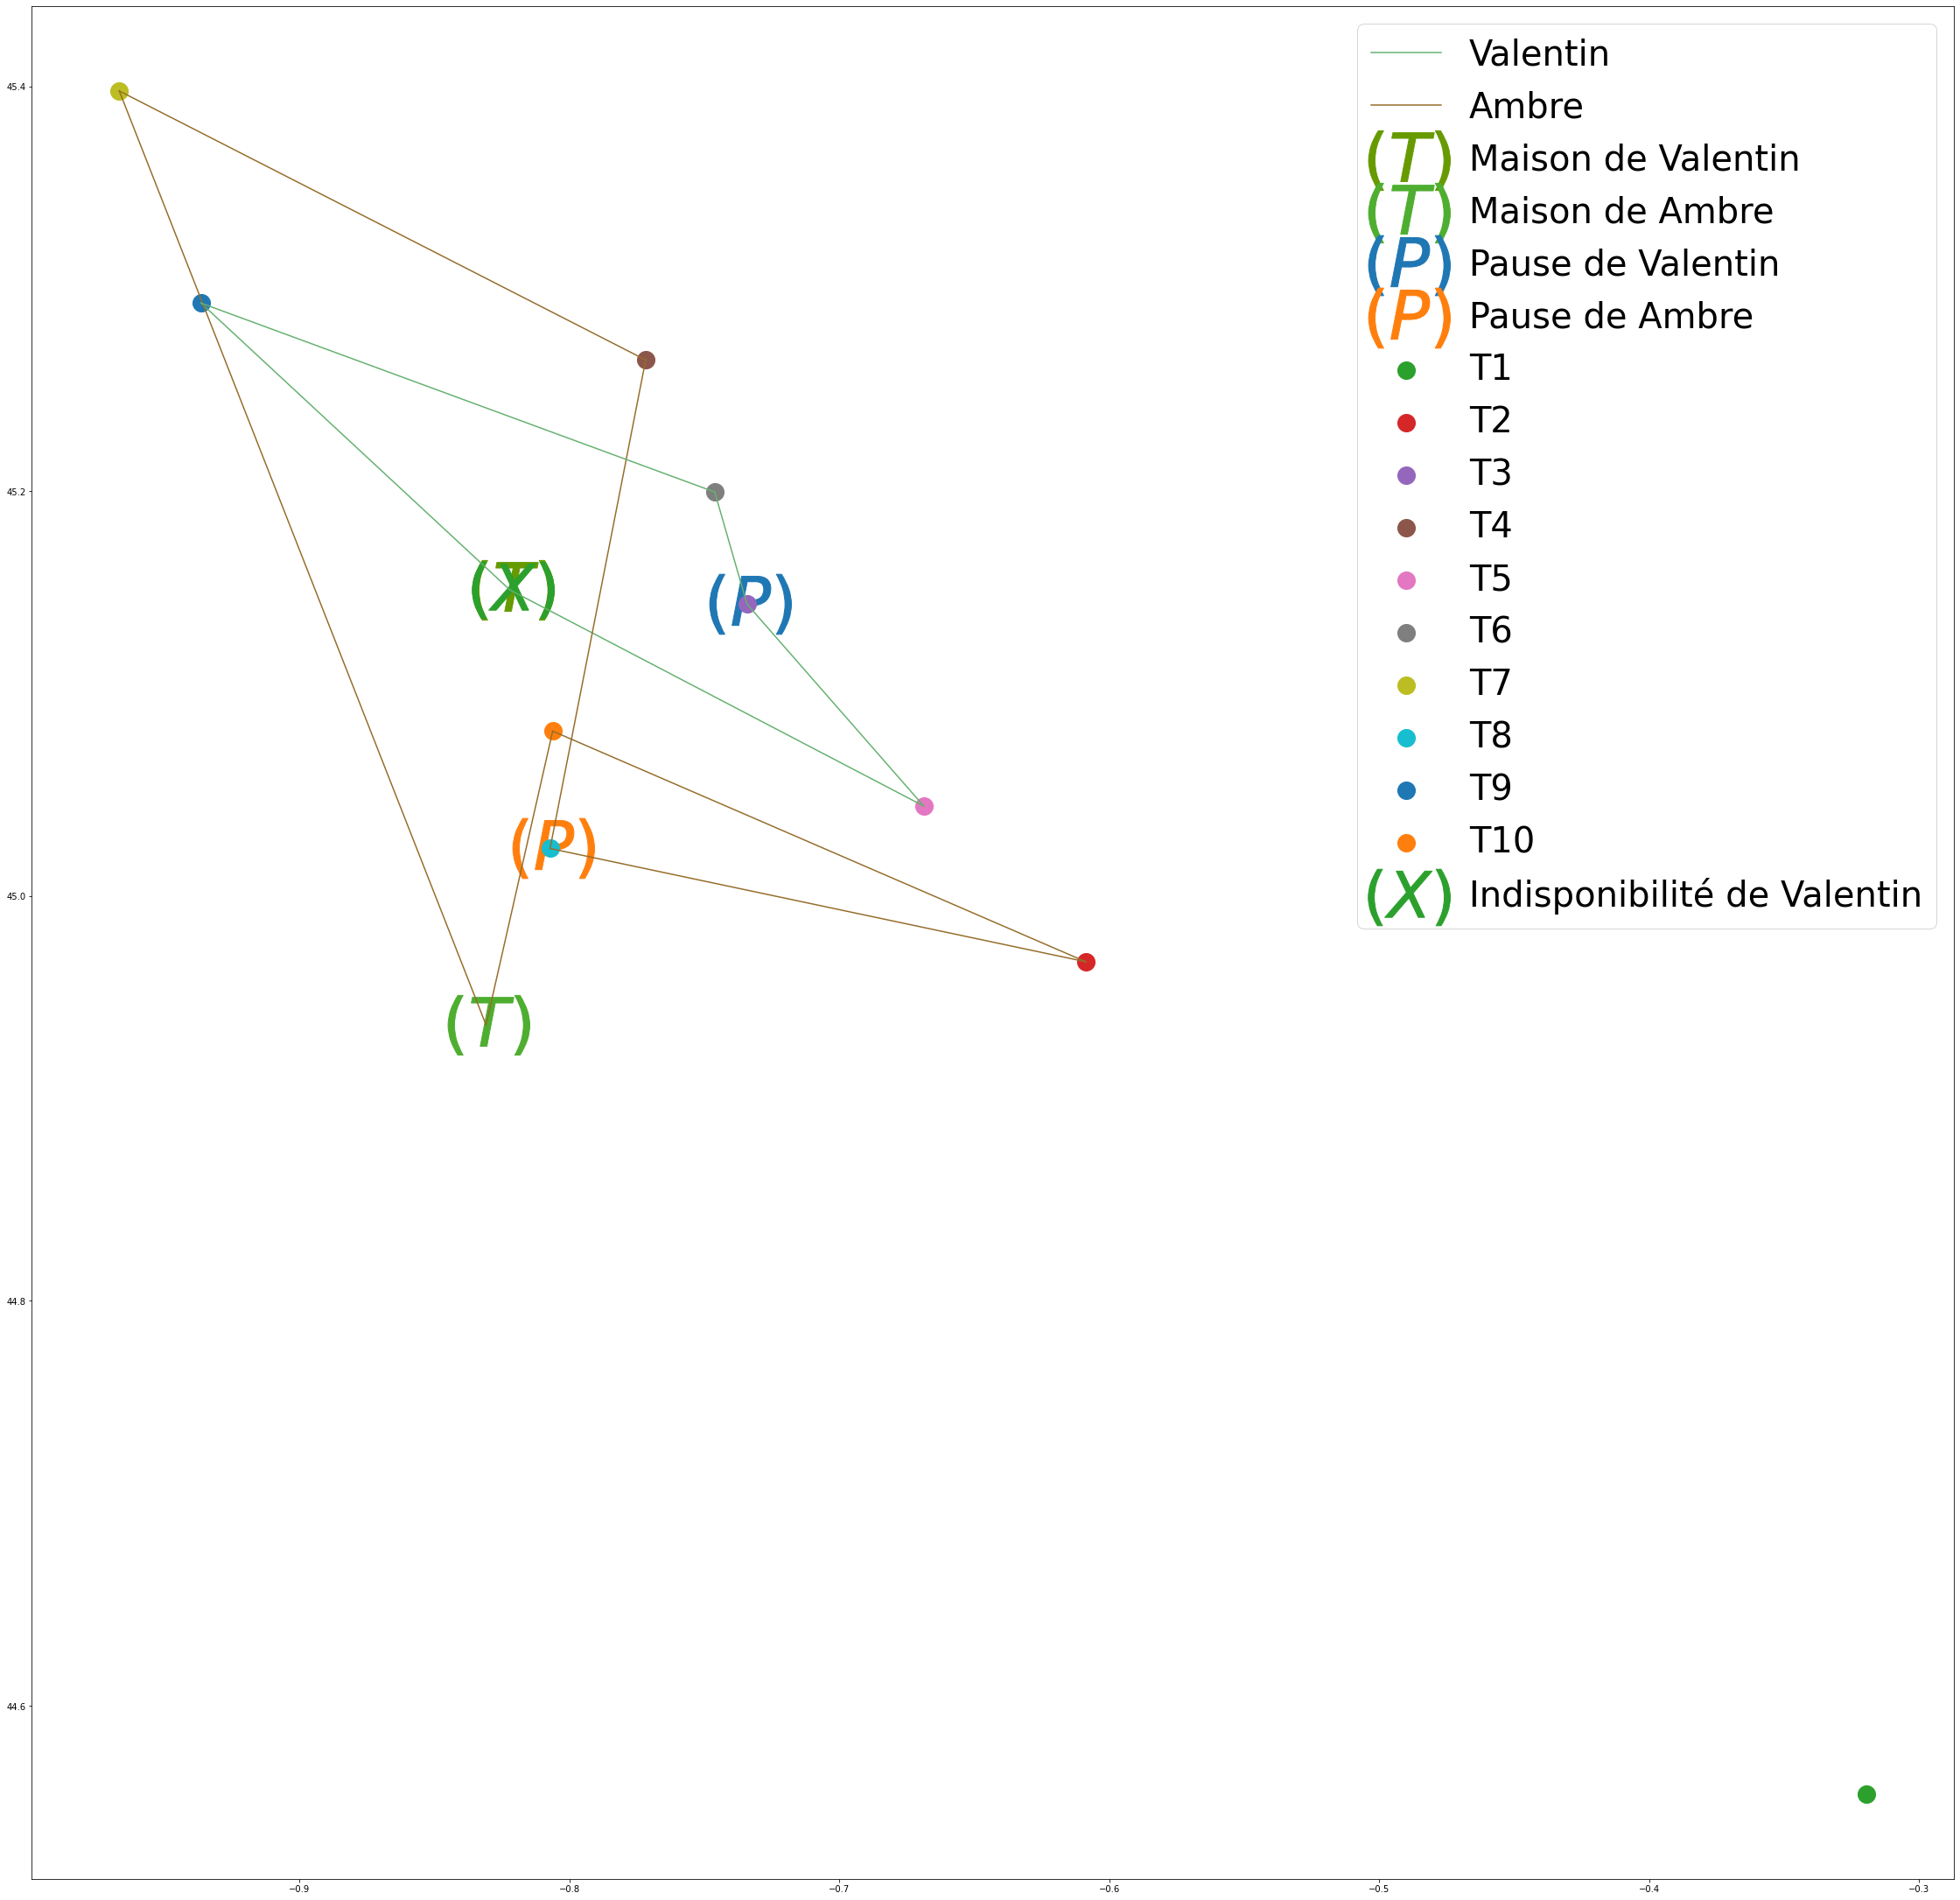

In [29]:
reload(utils)
from utils import plot_map
plot_map(Employee.list, Node.list, tasks, unavails, X, L, Z)